In [1]:
import pandas as pd
from xbbg import blp
import numpy as np
import matplotlib.pyplot as plt
import pytz
import time
from datetime import datetime, timedelta, date
from ipywidgets import HBox, RadioButtons, Button, Output
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.gridspec as gridspec
%matplotlib inline
import blpapi
import warnings
from blpapi import SessionOptions, Session, Request, CorrelationId
import threading
from concurrent.futures import ThreadPoolExecutor
import statsmodels.api as sm
import uuid

import os
import win32com.client
import matplotlib.pyplot as plt
from io import BytesIO
import base64

# warnings.filterwarnings("ignore")

In [2]:
x=blp.bdp(tickers=["CDX IG CDSI GEN 5Y CORP","ITRX EUR CDSI GEN 5Y CORP"], flds="ROLLING_SERIES").copy()
ig=x.iloc[0,0]
main =x.iloc[1,0]
ig_series = f"CDX IG CDSI S{ig} 5Y CORP"
main_series = f"ITRX EUR CDSI S{main} 5Y CORP"

df = pd.read_excel("BBG Data.xlsx",index_col=0, parse_dates=True)
bbg_datafile = df.copy()
last_update = df.dropna().index[-1]
all_bbg_tickers = [ig_series, main_series, "V2X INDEX", "VIX INDEX", 'GBTPGR10 Index', 'GFRN10 Index', 'GDBR10 Index']
new_data = pd.DataFrame()

for bbg_tickers in all_bbg_tickers:
    bbg_date = pd.to_datetime(last_update.date())
    data = None
    while True:
        try:
            f = blp.bdib(ticker = bbg_tickers, dt = bbg_date, interval = 1, ref='IndexYieldCurve')      
        except:
            if bbg_date > pd.to_datetime(datetime.now().date()):
                break
        data = pd.concat([data,f])
        bbg_date += timedelta(days=1)    
    try:
        data = data.iloc[:,[3]].copy()
        data.columns = [bbg_tickers]
    except:
        continue
    new_data = pd.concat([new_data, data],axis=1)

new_data.index = new_data.index.tz_convert('America/New_York')
new_data.index = new_data.index.tz_localize(None)
new_data = new_data.dropna(how="all").drop_duplicates().ffill().between_time("07:30","11:59")
new_data.columns = ["IG","Main","V2X", "VIX", "BTP","OAT","Bund"]
df = pd.concat([df, new_data]).drop_duplicates().sort_index().ffill().copy()
df.to_excel("BBG Data.xlsx")

In [3]:
df = pd.read_excel("BBG Data.xlsx", index_col=0, parse_dates=True)
email_df = df.copy()
email_df["Actual Main-IG"] = email_df["Main"] - email_df["IG"]
email_df["V2X - VIX"] = email_df["V2X"] - email_df["VIX"]
email_df["Sov_Avg"] = 0.5*(email_df["BTP"] + email_df["OAT"] - 2*email_df["Bund"])
email_df = email_df[["Actual Main-IG","V2X - VIX","Sov_Avg"]].copy()

In [4]:
########################################## Regression coefs calculations
period = 120 ############# it is only for calculating the daily coefs

all_data = df[["IG","Main","VIX","V2X"]].copy()
all_data = all_data[all_data.index>=datetime.now()-timedelta(days=period)]
all_data = all_data.sort_index().resample("15min").last().drop_duplicates()
all_data.index = all_data.index.tz_localize(None)
all_data.index.name = 'Date'

df = all_data.copy()
df.columns = ["IG","Main","VIX","V2X"]
df_ig = df[["IG"]].copy()
df_hy = df[["Main"]].copy()
df_vix = df[["VIX"]].copy()
df_v2x = df[["V2X"]].copy()
ig_price = df["IG"].iloc[-1]
main_price = df["Main"].iloc[-1]

df = pd.concat([df_ig, df_hy, df_vix, df_v2x], axis=1)
df.dropna(inplace=True)
df['Main-IG'] = df['Main'] - df['IG']
df['V2X - VIX'] = df['V2X'] - df['VIX']
df.drop(['Main','IG','V2X','VIX'], axis=1, inplace=True)

df1 = df[df.index.strftime('%H:%M:%S') == '11:15:00']
df1 = df1.copy()
df1.index = df1.index.date

security = ['GTITL10Y GOVT', 'GTFRF10Y GOVT', 'GTDEM10Y GOVT']
end_date = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
start_date = (datetime.now() - timedelta(days=period)).strftime('%Y-%m-%dT%H:%M:%S')

df_sov = blp.bdh(tickers=[security[0], security[1],security[2]], flds='PX_LAST', start_date=start_date, end_date=end_date )
df_sov.columns = ['_'.join(col) for col in df_sov.columns]

df_sov.columns = ['BTP','OAT','Bund']
df_sov['Sov_Avg'] = 0.5 * ( df_sov['BTP'] + df_sov['OAT'] - 2 * df_sov['Bund'] )
df_sov.drop(['BTP','OAT','Bund'], axis=1, inplace=True)

df = pd.concat([df1, df_sov],axis=1)
df.sort_index(inplace=True)
df.dropna(inplace=True)
df = df.diff(5)
df.dropna(inplace=True)

y = df.iloc[:, 0]
X = df.iloc[:, 1:3]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# print(model.summary())

const_col = 'const'
indep_col1 = df.columns[1]
indep_col2 = df.columns[2]

coefficients = model.params
constant = coefficients[const_col]
coef_col2 = coefficients[indep_col1]
coef_col3 = coefficients[indep_col2]

y_pred = model.predict(X)
dif = (y-y_pred)
dif_std = dif.std()
dif_mean = dif.mean()

In [5]:
######################### Live prices not needed for email
# def get_live_price(security):
#     session = blpapi.Session()
#     if not session.start():
#         print("Failed to start session.")
#         exit()
    
#     if not session.openService("//blp/refdata"):
#         print("Failed to open //blp/refdata")
#         exit()
    
#     refDataService = session.getService("//blp/refdata")
#     request = refDataService.createRequest("IntradayBarRequest")
    
#     start_time = datetime.now() - timedelta(days = 5)
#     end_time = datetime.now() + timedelta(days = 1)
    
#     request.set("security", security)
#     request.set("eventType", "TRADE")
#     request.set("interval", 1) 
#     request.set("startDateTime", start_time.strftime("%Y-%m-%dT%H:%M:%S"))
#     request.set("endDateTime", end_time.strftime("%Y-%m-%dT%H:%M:%S"))
    
#     session.sendRequest(request)
    
#     data = []
#     while True:
#         ev = session.nextEvent()
#         for msg in ev:
#             if msg.hasElement("barData"):
#                 barData = msg.getElement("barData").getElement("barTickData")
#                 for i in range(barData.numValues()):
#                     bar = barData.getValueAsElement(i)
#                     data.append({
#                         "time": bar.getElementAsDatetime("time"),
#                         "close": bar.getElementAsFloat("close"),
#                     })
#         if ev.eventType() == blpapi.Event.RESPONSE:
#             break

#     df = pd.DataFrame(data)
#     df.columns = ['Date',f'{security}']
#     df['Date'] = pd.to_datetime(df['Date'])
#     df.set_index('Date',inplace=True)
#     df.index = df.index.tz_localize('UTC').tz_convert('America/New_York')
#     return df.copy()
    
# security = [ig_series, main_series, 'V2X Index', 'VIX Index', 'GTITL10Y GOVT', 'GTFRF10Y GOVT', 'GTDEM10Y GOVT']

# df_ig = get_live_price(security[0])
# df_main = get_live_price(security[1])
# df_v2x = get_live_price(security[2])
# df_vix = get_live_price(security[3])
# df_btp = get_live_price(security[4])
# df_oat = get_live_price(security[5])
# df_bund = get_live_price(security[6])
# df = pd.concat([df_ig, df_main, df_v2x, df_vix, df_btp, df_oat, df_bund],axis=1)
# df.dropna(inplace=True)

# def get_yield_cds(df, ticker, output_field, override_field):
#     start_time = time.time()
#     sessionOptions = SessionOptions()
#     sessionOptions.setServerHost('localhost')
#     sessionOptions.setServerPort(8194)
#     session = Session(sessionOptions)
#     if not session.start():
#         print("Failed to start session.")
#         exit()
#     if not session.openService("//blp/refdata"):
#         print("Failed to open //blp/refdata")
#         exit()
#     refDataService = session.getService("//blp/refdata")
#     results = {}
#     correlation_id_to_px = {}
#     pending_requests = set()   
#     def send_requests(px_list):
#         for idx, px in px_list:
#             request = refDataService.createRequest("ReferenceDataRequest")
#             request.getElement("securities").appendValue(ticker)
#             request.getElement("fields").appendValue(output_field)
#             overrides = request.getElement("overrides")
#             override = overrides.appendElement()
#             override.setElement("fieldId", override_field)
#             override.setElement("value", str(px))
#             cid = CorrelationId(uuid.uuid4())
            
#             correlation_id_to_px[cid] = {'idx': idx, 'px': px}
#             pending_requests.add(cid)
#             session.sendRequest(request,correlationId=cid)
#     def event_loop():
#         while pending_requests:
#             ev = session.nextEvent()
#             for msg in ev:
#                 if msg.correlationIds():
#                     cid = msg.correlationIds()[0]
#                     data = correlation_id_to_px.get(cid)
#                     if data is not None:
#                         idx = data['idx']
#                         px = data['px']
#                         if idx not in results:
#                             results[idx] ={'px': px, 'fieldData_list': []}
#                         if msg.hasElement("securityData"):
#                             securityDataArray = msg.getElement("securityData")
#                             for securityData in securityDataArray.values():
#                                 fieldData = securityData.getElement("fieldData")
#                                 results[idx]['fieldData_list'].append(fieldData)
#                     pending_requests.discard(cid)
                    
#     px_values = list(zip(df.index.tolist(), df[ticker].tolist()))
#     send_requests(px_values)
#     event_loop()
#     output_rows = []
#     for idx in sorted(results.keys()):
#         data = results[idx]
#         px = data['px']
#         fieldData_list = data['fieldData_list']
#         for fieldData in fieldData_list:
#             if fieldData.hasElement(output_field):
#                 yield_value = fieldData.getElementAsFloat(output_field)
#                 output_rows.append({'Index': idx, 'Price':px, 'Yield':yield_value})
#             else:
#                 output_rows.append({'Index': idx, 'Price':px, 'Yield': None})
#     output_df = pd.DataFrame(output_rows)
#     output_df.set_index('Index',inplace=True)
#     output_df.sort_index(inplace=True)
#     output_df.drop(['Price'],axis=1,inplace=True)
#     output_df.columns = [f'{ticker} YLD']
#     output_df.index.name = 'Date'
#     session.stop()
#     return output_df

# df_check = get_yield_cds(df, security[4],'YAS_BOND_YLD','YAS_BOND_PX')
# df_check1 = get_yield_cds(df, security[5],'YAS_BOND_YLD','YAS_BOND_PX')
# df_check2 = get_yield_cds(df, security[6],'YAS_BOND_YLD','YAS_BOND_PX')

# df = pd.concat([df,df_check,df_check1,df_check2],axis=1)
# df.drop([security[4],security[5],security[6]],axis=1,inplace=True)
# df.columns = df.columns.str.replace(" YLD", "")

# df['Sov_Avg'] = 0.5 * (df['GTITL10Y GOVT'] + df['GTFRF10Y GOVT'] - 2 * df['GTDEM10Y GOVT'])
# df.drop([security[4],security[5],security[6]],axis=1,inplace=True)
# df['V2X - VIX'] = df['V2X Index'] - df['VIX Index']
# df['Actual Main-IG'] = df.iloc[:,1] - df.iloc[:,0]
# df.drop([security[0],security[1]],axis=1,inplace=True)
# df = df[['Actual Main-IG','V2X - VIX','Sov_Avg']]

# fields = ['PX_LAST','PX_LAST','PX_LAST','PX_LAST','YAS_BOND_YLD','YAS_BOND_YLD','YAS_BOND_YLD']

# def get_prices():
#     def create_session():
#         session_options = blpapi.SessionOptions()
#         session_options.setServerHost('localhost')
#         session_options.setServerPort(8194)
#         session = blpapi.Session(session_options)
#         if not session.start():
#             print("Failed to start session.")
#             return None
#         if not session.openService("//blp/refdata"):
#             print("Failed to open //blp/refdata")
#             return None
#         return session
    
#     def fetch_data(session, tickers, fields):
#         service = session.getService("//blp/refdata")
#         correlation_id_to_info = {}
#         pending_requests = set()
#         data = {}

#         for ticker, field in zip(tickers,fields):
#             request = service.createRequest("ReferenceDataRequest")
#             request.getElement("securities").appendValue(ticker)
#             request.getElement("fields").appendValue(field)
        
#             cid = blpapi.CorrelationId(uuid.uuid4())
#             correlation_id_to_info[cid] = {'ticker': ticker, 'field':field}
#             pending_requests.add(cid)
#             session.sendRequest(request, correlationId=cid)

#         while pending_requests:
#             event = session.nextEvent()
#             for msg in event:
#                 if msg.correlationIds():
#                     cid = msg.correlationIds()[0]
#                     if cid in pending_requests:
#                         pending_requests.remove(cid)
#                         info = correlation_id_to_info[cid]
#                         ticker = info['ticker']
#                         field = info['field']
#                         if msg.hasElement("securityData"):
#                             security_data_array = msg.getElement("securityData")
#                             for security_data in security_data_array.values():                                
#                                 field_data = security_data.getElement("fieldData")
#                                 if field_data.hasElement(field):
#                                     data[ticker] = field_data.getElementAsFloat(field)
#                                 else:
#                                     data[ticker] = None
#         return data
 
#     session = create_session()
    
#     data = fetch_data(session, security, fields)
#     session.stop()
#     df = pd.DataFrame(data, index = [0])
#     current_time_florida = datetime.now(pytz.timezone('America/New_York'))
#     df['Timestamp'] = current_time_florida
#     df.set_index('Timestamp', inplace=True)
#     df = df[security]
    
#     return df.copy()

<Figure size 640x480 with 0 Axes>

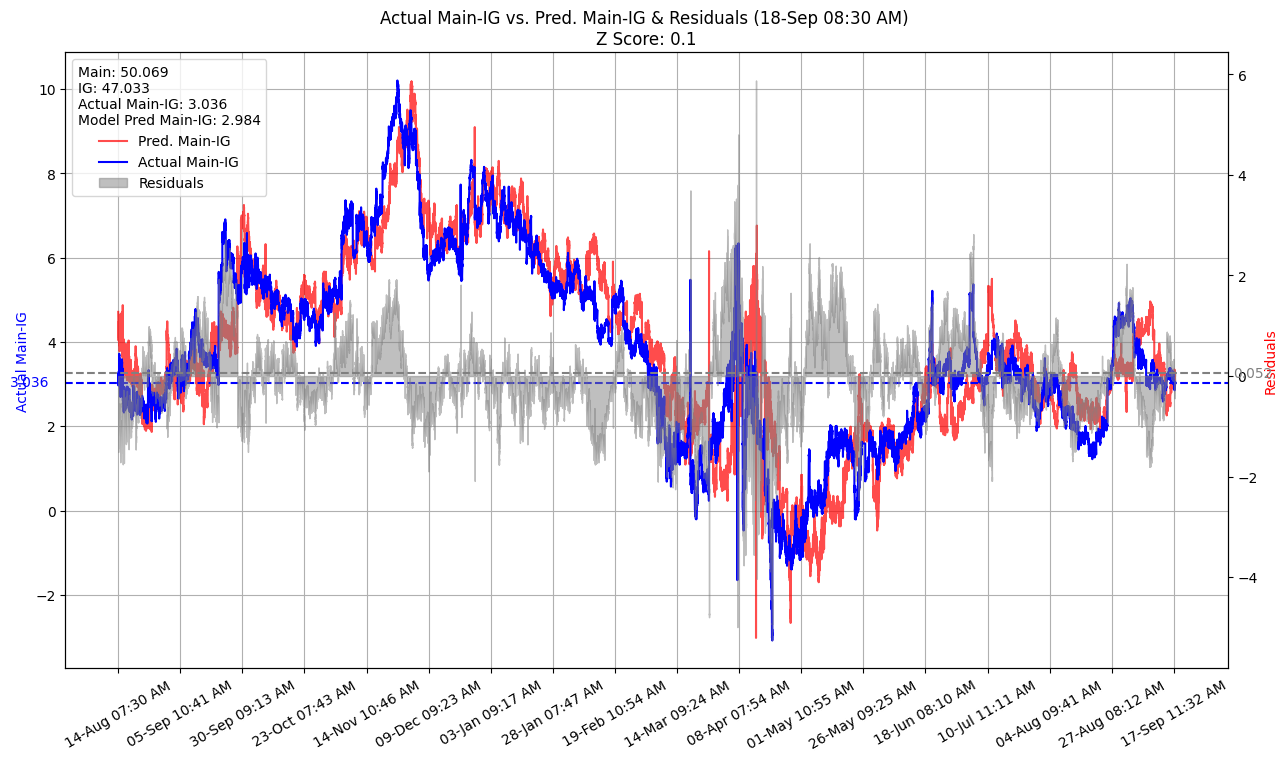

In [6]:
plt.ion()
df = email_df.copy()
buf = BytesIO()
def create_diff(df):
    df_reset = df.reset_index()
    df_reset.columns = ['time'] + list(df.columns)
    df_reset['t_prev'] = df_reset['time'] - pd.Timedelta(days=7)
    df_prev_values = pd.merge_asof(
        df_reset[['t_prev']].sort_values('t_prev'),
        df_reset[['time'] + list(df.columns)].sort_values('time'),
        left_on='t_prev',
        right_on='time',
        direction ='backward')
    df_combined = pd.concat([df_reset,df_prev_values[df.columns].add_suffix('_prev_week')], axis=1)
    for col in df.columns:
        df_combined[col +'_diff'] = df_combined[col] - df_combined[col+'_prev_week']
    df_combined.set_index('time',inplace=True)
    df_diff = df_combined.copy()
    df_diff['Pred. Main-IG_diff'] = constant + coef_col2 * df_diff['V2X - VIX_diff'] + coef_col3 * df_diff['Sov_Avg_diff']
    df_diff['Pred. Main-IG'] = df_diff['Actual Main-IG_prev_week'] + df_diff['Pred. Main-IG_diff']
    df_diff['Actual - Pred. Main-IG'] = df_diff['Actual Main-IG'] - df_diff['Pred. Main-IG']
    df_diff = df_diff[['Actual Main-IG','Pred. Main-IG','Actual - Pred. Main-IG']].copy()
    df_diff.dropna(inplace=True)
    df_diff.index.name = 'Timestamp'
    df_diff.index = df_diff.index.tz_localize(None)
    return df_diff.copy()

florida_tz=pytz.timezone('America/New_York')
current_time_florida=datetime.now(florida_tz)
start_time_florida=current_time_florida.replace(hour=3,minute=0,second=0,microsecond=0)
end_time_florida=current_time_florida.replace(hour=12,minute=0,second=0,microsecond=0)

def update_plot(dfA,main_price,ig_price):
    dft = dfA.copy()
    df = dfA.copy()
    df = create_diff(df)
    
    x_end_time = df.index[-1]
    x_start_time = df.index[0]
    current_time_florida_str = df.index[-1].strftime("%I:%M:%S %p")
    if df.index[-1].second!=0:
        df=df.iloc[:-1]
    x_ticks = pd.date_range(start=x_start_time, end=x_end_time, freq='60min')
    x_labels = [tick.strftime('%I:%M %p') for tick in x_ticks]
    
    recent_main_ig_value = df.iloc[-1]['Actual Main-IG']
    y_valuesB =  df['Actual Main-IG']
    y_valuesB1 =  df['Actual - Pred. Main-IG']
    y_valuesB2 =  df['Actual Main-IG'] - df['Actual - Pred. Main-IG']
    
    recent_diff_value = df.iloc[-1]['Actual - Pred. Main-IG']
    
    zscore = (recent_diff_value - dif_mean)/(dif_std)
    x_labelsB = df.index.strftime("%d-%b %I:%M %p")

    plt.clf()
    
    fig, ax = plt.subplots(figsize=(15, 8))

    # ax.plot(range(len(y_valuesB)),y_valuesB,color='blue',linestyle='-', label='Actual Main-IG')
    # stepB = 90*10*5
    # ax.set_xticks(range(0,len(x_labelsB),stepB))
    # ax.set_xticklabels(x_labelsB[::stepB],rotation=45)
    # ax.axhline(y=recent_main_ig_value, color='blue', linestyle='--', label='Recent Value')
    # ax.grid(True,axis='x')
    # ax.grid(True,axis='y')
    # ax.set_ylabel('Actual Main-IG',color='blue')
    # ax_2 = ax.twinx()
    # # ax_2.plot(range(len(y_valuesB1)),(y_valuesB1-dif_mean)/(dif_std),color='lightgray',linestyle='-', label ='Z Score', alpha = 0.5)
    # # ax_2.set_ylabel('6M Z Score',color='red')
    # ax_2.plot(range(len(y_valuesB1)),y_valuesB1,color='lightgray',linestyle='-', label ='Residuals', alpha = 0.5)
    # ax_2.set_ylabel('Residuals',color='red')
    # ax.set_title('Plot of Actual Main-IG')
    # ax_2.axhline(y=recent_diff_value, color='lightgray', linestyle='--', label='Current Residual')
    # # ax_2.axhline(y=zscore, color='lightgray', linestyle='--', label='Current Z Score Value')
    # ax.text(x=-0.065*len(x_labelsB), y=recent_main_ig_value, s=f'{recent_main_ig_value:.3f}',color='blue', verticalalignment='center', horizontalalignment='right')
    # ax_2.text(x=1.055*len(x_labelsB), y=recent_diff_value, s=f'{recent_diff_value:.3f}',color='lightgray', verticalalignment='center', horizontalalignment='left')
    # # ax_2.text(x=1.055*len(x_labelsB), y=zscore, s=f'{zscore:.3f}',color='lightgray', verticalalignment='center', horizontalalignment='left')
    # handles_ax, labels_ax = ax.get_legend_handles_labels()
    # handles_ax_2, labels_ax_2 = ax_2.get_legend_handles_labels()
    # handlesB = handles_ax + handles_ax_2
    # labelsB = labels_ax + labels_ax_2
    # ax.legend(handlesB, labelsB, loc='upper left',title=f'Main: {main_price:.3f}\
    # \nIG: {ig_price:.3f}\nActual Main-IG: {main_price-ig_price:.3f}\
    # \nModel Pred Main-IG: {main_price-ig_price-recent_diff_value:.3f}\
    # \nZ Score: {zscore:.3f}\nTime: {current_time_florida_str}')
    # # Diff: {recent_diff_value:.3f}\
    # plt.close()
    # display(fig)
    # clear_output(wait=True)

    ax.plot(range(len(y_valuesB2)), y_valuesB2, color='red', alpha=0.7, linestyle='-', label='Pred. Main-IG')
    ax.plot(range(len(y_valuesB)), y_valuesB, color='blue', linestyle='-', label='Actual Main-IG')
    stepB = 90*10*5
    ax.set_xticks(range(0, len(x_labelsB), stepB))
    ax.set_xticklabels(x_labelsB[::stepB], rotation=30)
    ax.axhline(y=recent_main_ig_value, color='blue', linestyle='--')#, label='Recent Value')
    ax.grid(True, axis='x')
    ax.grid(True, axis='y')
    ax.set_ylabel('Actual Main-IG', color='blue')
    
    ax_2 = ax.twinx()
    ax_2.fill_between(range(len(y_valuesB1)), y_valuesB1, color='gray', alpha=0.5, label='Residuals')
    ax_2.set_ylabel('Residuals', color='red')
    ax.set_title(f'Actual Main-IG vs. Pred. Main-IG & Residuals ({email_df.index[-1].strftime("%d-%b %I:%M %p")}) \nZ Score: {zscore:.1f}')
    # ax.set_title('Main-IG = blue & left; Pred. Main-IG = red & left axis; Residuals = coral & right axis')
    ax_2.axhline(y=recent_diff_value, color='gray', linestyle='--')#, label='Current Residual')
    ax.text(x=-0.065 * len(x_labelsB), y=recent_main_ig_value, s=f'{recent_main_ig_value:.3f}', color='blue',
            verticalalignment='center', horizontalalignment='right')
    ax_2.text(x=1.055 * len(x_labelsB), y=recent_diff_value, s=f'{recent_diff_value:.3f}', color='gray',
             verticalalignment='center', horizontalalignment='left')
    handles_ax, labels_ax = ax.get_legend_handles_labels()
    handles_ax_2, labels_ax_2 = ax_2.get_legend_handles_labels()
    handlesB = handles_ax + handles_ax_2
    labelsB = labels_ax + labels_ax_2
    ax.legend(handlesB, labelsB, loc='upper left', title=f'Main: {main_price:.3f}\
    \nIG: {ig_price:.3f}\nActual Main-IG: {main_price - ig_price:.3f}\
    \nModel Pred Main-IG: {main_price - ig_price - recent_diff_value:.3f}')
    plt.savefig("Plots.png")    
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.show()
    clear_output(wait=True)

df.index.name = 'Date'

update_plot(df,main_price,ig_price)

In [7]:

# while True:
#     update_plot(df,main_price,ig_price)
#     current_time_florida=datetime.now(florida_tz)
#     securities = [main_series, ig_series,'V2X INDEX','VIX INDEX','GTITL10Y GOVT', 'GTFRF10Y GOVT', 'GTDEM10Y GOVT']
#     start_date = (datetime.today() - timedelta(days=7)).strftime('%Y-%m-%d')
#     end_date = (datetime.today() + timedelta(days=2)).strftime('%Y-%m-%d')
#     trading_dates = blp.bdh( tickers=securities, start_date=start_date, end_date=end_date )
    
#     if pd.to_datetime(datetime.today().strftime('%Y-%m-%d')) == pd.to_datetime(trading_dates.index[-1]) and not trading_dates.iloc[-1].isna().any():
#         mstatus = 'TRAD'
#     else:
#         mstatus = 'CLOSED'

#     while mstatus=='TRAD' and current_time_florida>=start_time_florida and current_time_florida<=end_time_florida:
#         df_new = get_prices()
#         df_new['Sov_Avg'] = 0.5 * (df_new['GTITL10Y GOVT'] + df_new['GTFRF10Y GOVT'] - 2 * df_new['GTDEM10Y GOVT'])
#         df_new.drop([security[4],security[5],security[6]],axis=1,inplace=True)
#         df_new['V2X - VIX'] = df_new['V2X Index'] - df_new['VIX Index']
#         df_new['Actual Main-IG'] = df_new.iloc[:,1] - df_new.iloc[:,0]
#         main_price = df_new.iloc[0,1]
#         ig_price = df_new.iloc[0,0]
#         df_new.drop([security[0],security[1]],axis=1,inplace=True)
#         df_new = df_new[['Actual Main-IG','V2X - VIX','Sov_Avg']]
#         df_new.index.name = 'Date'
#         df = pd.concat([df,df_new])
#         df.sort_index(inplace=True)
#         df.dropna(inplace=True)
        
#         data = df.copy()
#         resampled_data = data.resample('1min').last()                
#         last_second_row = data.tail(1)
#         result = pd.concat([resampled_data,last_second_row])
#         result = result.sort_index()
#         result.reset_index(inplace=True)                
#         cols = result.columns.tolist()
#         cols = ['Date'] + [col for col in cols if col != 'Date']
#         result = result[cols]
#         result.set_index('Date',inplace=True)
#         df = result.copy()
        
#         update_plot(df,main_price,ig_price)
#         break

In [8]:
import os
import win32com.client

folder_path = r'J:\7A. IG-Main Email'

images = [f for f in os.listdir(folder_path) if f.endswith('.png')]

outlook = win32com.client.Dispatch("Outlook.Application")
mail = outlook.CreateItem(0)

html_body = '<html><body>'
for j, image in enumerate(images):
    file_path = os.path.join(folder_path, image)
    if os.path.exists(file_path):
        cid = f'image{j}'  # Create a unique CID for each image
        attachment = mail.Attachments.Add(Source=file_path)
        attachment.PropertyAccessor.SetProperty("http://schemas.microsoft.com/mapi/proptag/0x3712001F", cid)
        html_body += f'<br><br><img src="cid:{cid}"><br>'
    else:
        print(f"File {file_path} not found")

html_body += '</body></html>'
mail.HTMLBody = html_body

mail.Subject = 'Main-IG (auto)'
mail.CC = 'vasu.sharma@iiicm.com'
mail.To = 'spyros.michas@iiicm.com'
mail.Send()
print("Email sent successfully")

Email sent successfully
